# ECBM E4040  Assignment 1, Task 2: Multilayer Perceptron (MLP)
This is the second part of the assignment. You will get to know how to build basic fully connected neural network.

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from ecbm4040.cifar_utils import load_data

# Plot configurations
% matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

## Load Data

In [2]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 3072) (1000, 3072) (10000, 3072) (100, 3072)
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Development data shape: (100, 3072)
Development data shape (100,)


## Part 1: Basic layers

### Create basic layer functions

<span style="color:red"><strong>TODO</strong></span>: Complete functions **affine_forward**, **affine_backward** in **./ecbm4040/layer_funcs.py**.

In [3]:
from ecbm4040.layer_funcs import affine_forward
from ecbm4040.layer_funcs import affine_backward

# generate data for checking
x = X_dev
w = np.random.rand(x.shape[1],100)
b = np.random.rand(100)
dout = np.ones((x.shape[0],100))

## Affine function -- H = W*X + b
out = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, x, w, b)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **relu_forward**, **relu_backward** in **./ecbm4040/layer_funcs.py**.

In [9]:
from ecbm4040.layer_funcs import relu_forward
from ecbm4040.layer_funcs import relu_backward

## Activation layers -- Here we introduce ReLU activation function
## since it is the most commonly used in computer vision problems.
## However, you can also try to implement 
## other activation functions like sigmoid, tanh etc.
x = X_dev
dout = np.ones(x.shape)
## ReLU
out = relu_forward(x)
dx = relu_backward(dout, x)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## check by tf.gradients()
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
out_tf = tf.nn.relu(x_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)[0]
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check = sess.run(dx_tf)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is out correct? True
Is dx correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete functions **softmax_loss** in **./ecbm4040/layer_funcs.py**

In [5]:
from ecbm4040.layer_funcs import softmax_loss

## generate some random data for testing
x = np.random.rand(100,10)
y = np.argmax(x, axis=1)

loss, dx = softmax_loss(x, y)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## tensorflow gradients
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
y_tf = tf.Variable(y, name='y')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= x_tf, labels=tf.one_hot(y_tf,10))
loss_tf = tf.reduce_mean(cross_entropy)
dx_tf = tf.gradients(loss, x)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(loss_tf, x_tf)
with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf)
    dx_check = sess.run(dx_tf)

## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))

Is loss correct? True
Is dx correct? True


### Create a single layer

Now try to combine an affine function and a nonlinear activation function into a single fully-connected layer. Edit the code in ./ecbm4040/layer_utils.py

$$\mathbf{O} = activation(\mathbf{W} \times \mathbf{X} + \mathbf{b})$$

For this assignment, you need to create two types of layers as below. You can get started with the skeleton code in ./ecbm4040/layer_utils.py. The basic class structure has been provided, and you need to fill in the "TODO" part(s). 

* DenseLayer -- Affine transform >> ReLU
```
Class DenseLayer:
    Variables: weights, bias 
    Functions: 
        __init__: given (input_dim, output_dim, weight_scale)
        feedforward: TODO
        backforward: TODO      
```    
* AffineLayer -- Affine transform and the class structure is similar to DenseLayer

<span style="color:red"><strong>TODO</strong></span>: Complete function **DenseLayer** in **./ecbm4040/layer_utils.py**

In [10]:
## First, let's make a dense layer
from ecbm4040.layer_utils import DenseLayer

## Affine + ReLU
test_dense = DenseLayer(input_dim=3072,output_dim=100)
w, b = test_dense.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_dense.feedforward(x)
dx = test_dense.backward(dout)
dw, db = test_dense.gradients

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.nn.relu(tf.matmul(x_tf,w_tf) + b_tf)
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


<span style="color:red"><strong>TODO</strong></span>: Complete function **AffineLayer** in **./ecbm4040/layer_utils.py**

In [11]:
from ecbm4040.layer_utils import AffineLayer

## Affine
test_affine = AffineLayer(input_dim=3072,output_dim=100)
w, b = test_affine.params

## Data for correctness check
x = X_dev
dout = np.ones((x.shape[0], 100))

out = test_affine.feedforward(x)
dx = test_affine.backward(dout)
dw, db = test_affine.gradients

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## Use tf.gradients() to check
tf.reset_default_graph()
x_tf = tf.Variable(x, name='x')
w_tf = tf.Variable(w, name='w')
b_tf = tf.Variable(b, name='b')
out_tf = tf.matmul(x_tf,w_tf) + b_tf
init = tf.global_variables_initializer()

dx_tf = tf.gradients(out_tf, x_tf)
dw_tf = tf.gradients(out_tf, w_tf)
db_tf = tf.gradients(out_tf, b_tf)
tf_output = (dx_tf[0], dw_tf[0], db_tf[0])
with tf.Session() as sess:
    sess.run(init)
    out_check = sess.run(out_tf)
    dx_check, dw_check, db_check = sess.run(tf_output)

## Print validation result
print("Is out correct? {}".format(np.allclose(out, out_check)))
print("Is dx correct? {}".format(np.allclose(dx, dx_check)))
print("Is dw correct? {}".format(np.allclose(dw, dw_check)))
print("Is db correct? {}".format(np.allclose(db, db_check)))

Is out correct? True
Is dx correct? True
Is dw correct? True
Is db correct? True


## Part 2: More Backpropogation

Complete the class **TwoLayerNet** in **./ecbm4040/classifiers/twolayernet.py**. Through this experiment, you will create a two-layer neural network and learn about the backpropagation mechanism. The network structure is like **input >> DenseLayer >> AffineLayer >> softmax loss >> output**. Complete "TODO" part(s).
```
Class TwoLayerNet:   
    Functions: 
        __init__: GIVEN
        loss: TODO - calculate cross entropy loss and gradients wst all weights and bias.
        step: TODO - a single update all weights and bias by SGD.
        predict: TODO - output result(classification accuracy) based on input data
    
    Variables:
        layers
```

<span style="color:red"><strong>TODO</strong></span>: Complete class **TwoLayerNet** in **./ecbm4040/classifiers/twolayernet.py**

In [14]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

## Define a model
model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=1e-4)
W1, b1 = model.layer1.params
W2, b2 = model.layer2.params
## Backprogation -- Finish loss function and gradients calculation in TwoLayerNet
loss = model.loss(X_dev, y_dev)

################################################
# THE FOLLOWING CODE IS JUST FOR CHECKING.     #
# NO NEED TO CHANGE IT.                        #
################################################
## Check loss by tensorflow
x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.uint8, shape=(None,))

W1_tf = tf.Variable(W1.astype('float32'))
b1_tf = tf.Variable(b1.astype('float32'))
W2_tf = tf.Variable(W2.astype('float32'))
b2_tf = tf.Variable(b2.astype('float32'))
h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + 1e-4*L2_loss 
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    loss_check = sess.run(loss_tf, feed_dict={x_tf: X_dev, y_tf: y_dev})
    
## Print validation result
print("Is loss correct? {}".format(np.allclose(loss, loss_check)))

Is loss correct? True


### Train a two-layer network

#### Import functions for training and testing

In [15]:
from ecbm4040.train_funcs import train, test

#### Start training
We provide you the **train( )** function in **./ecbm4040/train_func.py**, please go through it before you begin to train your network.

In [16]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

## TODO: Use previous layers to create a two layer neural network
## input->(affine->activation)->(affine->softmax)->output
## The recommended activation function is ReLU. And you can 
## also make a comparison with other activation function to see
## any difference.
model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=1e-4, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 5e-4
verbose = True
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, optim='SGD', verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
5000/49000 loss: 3.2115302927284204
10000/49000 loss: 2.4324721762637154
15000/49000 loss: 2.1404406451465814
20000/49000 loss: 1.985931576030614
25000/49000 loss: 1.9677232862905898
30000/49000 loss: 1.8681817718555889
35000/49000 loss: 1.9508616978355215
40000/49000 loss: 1.820219183978683
45000/49000 loss: 1.7692071857591767
epoch 1: valid acc = 0.403, new learning rate = 0.000475
5000/49000 loss: 1.6797821552758818
10000/49000 loss: 1.6965799641964465
15000/49000 loss: 1.6170944157598177
20000/49000 loss: 1.634567220099597
25000/49000 loss: 1.5729392869915795
30000/49000 loss: 1.6596194637301442
35000/49000 loss: 1.5922727396400262
40000/49000 loss: 1.6517028266530271
45000/49000 loss: 1.5963867293115417
epoch 2: valid acc = 0.464, new learning rate = 0.00045125
5000/49000 loss: 1.5368539145688402
10000/49000 loss: 1.473569242694122
15000/49000 loss: 1.5093262146537119
20000/49000 loss: 1.527527292855365
25000/49000 loss: 1.5746512841901867
30000/

0.5074

<span style="color:red"><strong>TODO</strong></span>: Plot training and validation accuracy history of each epoch

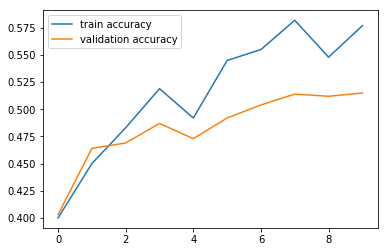

In [17]:
# plot the accuracy history
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

#### Visulize the weight variable in the first layer.

Visualization of the intermediate weights can help you get an intuitive understanding of how the network works, especially in  Convolutional Neural Networks (CNNs).

In [18]:
from ecbm4040.display_funcs import visualize_pics

num of feature vectors: 100


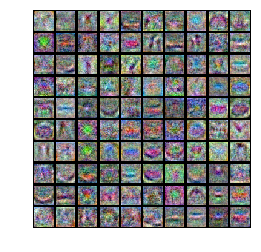

In [19]:
weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
## visualization
visualize_pics(pics)

### Get test accuracy greater than 50%

For this part, you need to train a better two-layer net. The requirement is to get test accuracy better than 50%. If your accuracy is lower, for each 1% lower than 50%, you will lose 5 points.

Here are some recommended methods for improving the performance. Feel free to try any other method as you see fit.

1. Hyperparameter tuning: reg, hidden_dim, lr, learning_decay, num_epoch, batch_size, weight_scale.
2. Adjust training strategy: Randomly select a batch of samples rather than selecting them orderly. 
3. Try new optimization methods: Now we are using SGD, you can try SGD with momentum, adam, etc.
4. Early-stopping.
5. Good (better) initial values for weights in the model.
6. Try use PCA or other preprocessing methods. (Try task3-dim_reduction.ipynb before finishing this task)

A comparison between SGD and SGD with momentum.

* Stochastic gradient descent - SGD
    ```
    w = w - learning_rate * gradient 
    ```
* SGD with momentum
    ```
    v = momentum*v + learning_rate * gradient
    w = w - v
    ```

<span style="color:red"><strong>TODO</strong></span>: See below

In [20]:
from ecbm4040.classifiers.twolayernet import TwoLayerNet

model = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10, reg=0.35, weight_scale=5e-3)

num_epoch = 20
batch_size = 500
lr = 1e-3
verbose = True

train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                                     num_epoch=num_epoch, batch_size=batch_size, 
                                     learning_rate=lr)#, verbose=verbose
test(model, X_test, y_test)

number of batches for training: 98


/home/ecbm4040/dl-hw/hw1/assignment1/ecbm4040/layer_funcs.py:114: RuntimeWarning: divide by zero encountered in log
  correct_score = np.log(correct_score)


epoch 1: valid acc = 0.212, new learning rate = 0.00095
epoch 2: valid acc = 0.455, new learning rate = 0.0009025
epoch 3: valid acc = 0.475, new learning rate = 0.000857375
epoch 4: valid acc = 0.474, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.477, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.504, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.509, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.496, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.499, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.512, new learning rate = 0.0005987369392383785
epoch 11: valid acc = 0.516, new learning rate = 0.0005688000922764595
epoch 12: valid acc = 0.509, new learning rate = 0.0005403600876626365
epoch 13: valid acc = 0.499, new learning rate = 0.0005133420832795047
epoch 14: valid acc = 0.525, new learning rate = 0.00048767497911552944
epoch 15: valid acc = 0.539, new learning rate = 0.

0.5118

#### <span style="color:red"><strong>TODO</strong></span>: Show your best result, including accuracy and weights of the first layer

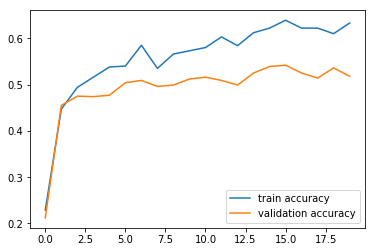

In [21]:
## TODO: plot training and validation accuracy
plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.legend()
plt.show()

num of feature vectors: 100


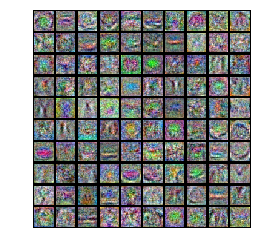

In [22]:
## TODO: Visualize weights

weights = model.layer1.params[0]
pics = weights.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
visualize_pics(pics)

### Save your best model in a dictionary 

In [23]:
## Create "save_model" folder if it does not exist
save_dir = "./save_models/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Save your model
save_params = model.save_model()
with open("./save_models/best_model.pkl", "wb") as output_file:
    pickle.dump(save_params, output_file)

In [ ]:
## Load your model
#with open("./save_models/best_model.pkl", "rb") as input_file:
#    load_params = pickle.load(input_file)
    
#model.update_model(load_params)

## Part 3: Multilayer Net 

Complete the class **MLP** in **./ecbm4040/classifiers/network.py**. It should allow arbitrary settings for the number of hidden layers as well as the number of hidden neurons in each layer. **MLP** has a similar structure as a **TwoLayerNet** network. Complete the "TODO" part.

```
class MLP:
    functions: __init__, loss, step, predict, check_accuracy
    variables: layers
```

In [26]:
from ecbm4040.classifiers.mlp import MLP

## TODO: Use a sequence of layers to create a multiple layer neural network
## input->(affine->activation)-> ... ->(affine->activation)->(affine->softmax)->output
model = MLP(input_dim=3072, hidden_dims=[100, 100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 98
epoch 1: valid acc = 0.24, new learning rate = 0.0095
epoch 2: valid acc = 0.4, new learning rate = 0.009025
epoch 3: valid acc = 0.438, new learning rate = 0.00857375
epoch 4: valid acc = 0.482, new learning rate = 0.0081450625
epoch 5: valid acc = 0.463, new learning rate = 0.007737809374999999
epoch 6: valid acc = 0.479, new learning rate = 0.007350918906249998
epoch 7: valid acc = 0.49, new learning rate = 0.006983372960937498
epoch 8: valid acc = 0.496, new learning rate = 0.006634204312890623
epoch 9: valid acc = 0.476, new learning rate = 0.006302494097246091
epoch 10: valid acc = 0.5, new learning rate = 0.005987369392383786
test acc: 0.5045


0.5045

## Part 4: Tensorflow MLP
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net. You need to implement a multi-layer with 3 or 4 layers.

In [27]:
## Demo: Two-layer net in tensorflow.
hidden_dim = 100
reg_tf = tf.constant(0.01)

x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

W1_tf = tf.Variable(1e-2*np.random.rand(3072, hidden_dim).astype('float32'))
b1_tf = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
W2_tf = tf.Variable(1e-2*np.random.rand(hidden_dim, 10).astype('float32'))
b2_tf = tf.Variable(np.zeros((10,)).astype('float32'))

h1_tf = tf.nn.relu(tf.matmul(x_tf, W1_tf) + b1_tf)
h2_tf = tf.matmul(h1_tf, W2_tf) + b2_tf

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits= h2_tf, labels=tf.one_hot(y_tf,10))
L2_loss = tf.nn.l2_loss(W1_tf) + tf.nn.l2_loss(W2_tf)
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 

init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-3).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(h2_tf,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(10):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.289000004529953
epoch 2: valid acc = 0.3370000123977661
epoch 3: valid acc = 0.30799999833106995
epoch 4: valid acc = 0.32600000500679016
epoch 5: valid acc = 0.3409999907016754
epoch 6: valid acc = 0.37299999594688416
epoch 7: valid acc = 0.39800000190734863
epoch 8: valid acc = 0.41200000047683716
epoch 9: valid acc = 0.4009999930858612
epoch 10: valid acc = 0.4129999876022339
test acc = 0.4129999876022339


<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" or "dictionary" to store your network parameters, ie., weights and bias. Besides, consider to use a loop to create your MLP network.

In [28]:
# Four-layer net in tensorflow.
hidden_dim_1 = 10
hidden_dim_2 = 50
hidden_dim_3 = 10
reg_tf = tf.constant(0.02)

weights = {
    'w1': tf.Variable(1e-2*np.random.rand(3072, hidden_dim_1).astype('float32')),
    'w2': tf.Variable(1e-2*np.random.rand(hidden_dim_1, hidden_dim_2).astype('float32')),
    'w3': tf.Variable(1e-2*np.random.rand(hidden_dim_2, hidden_dim_3).astype('float32')),
    'w4': tf.Variable(1e-2*np.random.rand(hidden_dim_3, 10).astype('float32'))
}

biases = {
    'b1': tf.Variable(np.zeros((hidden_dim_1,)).astype('float32')),
    'b2': tf.Variable(np.zeros((hidden_dim_2,)).astype('float32')),
    'b3': tf.Variable(np.zeros((hidden_dim_3,)).astype('float32')),
    'b4': tf.Variable(np.zeros((10,)).astype('float32'))
}


x_tf = tf.placeholder(tf.float32, shape=(None, 3072))
y_tf = tf.placeholder(tf.int64, shape=(None,))

H=[]
X=x_tf
L2_loss=0
for i in range(3):
    L2_loss+=tf.nn.l2_loss(weights['w'+str(i+1)])
    h=tf.nn.relu(tf.matmul(X, weights['w'+str(i+1)]) + biases['b'+str(i+1)])
    H.append(h)
    X=h
    
H.append(tf.matmul(H[-1], weights['w4']) + biases['b4'])
L2_loss+=tf.nn.l2_loss(weights['w4'])

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= H[-1], labels=tf.one_hot(y_tf,10))
loss_tf = tf.reduce_mean(cross_entropy) + reg_tf*L2_loss 
    
init = tf.global_variables_initializer()
train_step = tf.train.GradientDescentOptimizer(1e-2).minimize(loss_tf)
correct_prediction = tf.equal(y_tf, tf.argmax(H[-1],1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
with tf.Session() as sess:
    sess.run(init)
    for e in range(20):
        for i in range(num_batch):
            batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train_step, feed_dict={x_tf: batch_xs, y_tf: batch_ys})
        val_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
        print('epoch {}: valid acc = {}'.format(e+1, val_acc))
    
    test_acc = sess.run(accuracy, feed_dict={x_tf: X_val, y_tf: y_val})
    print('test acc = {}'.format(test_acc))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

epoch 1: valid acc = 0.14800000190734863
epoch 2: valid acc = 0.1469999998807907
epoch 3: valid acc = 0.1459999978542328
epoch 4: valid acc = 0.1469999998807907
epoch 5: valid acc = 0.15000000596046448
epoch 6: valid acc = 0.17800000309944153
epoch 7: valid acc = 0.1940000057220459
epoch 8: valid acc = 0.19300000369548798
epoch 9: valid acc = 0.1979999989271164
epoch 10: valid acc = 0.20499999821186066
epoch 11: valid acc = 0.20800000429153442
epoch 12: valid acc = 0.20200000703334808
epoch 13: valid acc = 0.2029999941587448
epoch 14: valid acc = 0.20200000703334808
epoch 15: valid acc = 0.20399999618530273
epoch 16: valid acc = 0.20499999821186066
epoch 17: valid acc = 0.20499999821186066
epoch 18: valid acc = 0.20900000631809235
epoch 19: valid acc = 0.20900000631809235
epoch 20: valid acc = 0.2